In [9]:

import numpy as np
import pandas

import skimage.data
import skimage.transform
from skimage import data, io, filters

import tensorflow as tf

In [10]:
import math

width = 128
height = 92
# Import Labels
labels = []
imagePaths = []
lastTrackingAngle = 0
lastSpeed = 0
fname = "C:/Users/ndmmc/Desktop/CarData/capture201708061514/accelClass.txt"
base = "C:/Users/ndmmc/Desktop/CarData"
with open(fname) as f:
    content = f.readlines()
    for i in range(1,len(content),2):
        line = content[i-1] + content[i]
        line = line.split(",")
        speedString = (line[1].split(" "))[2]
        speed = float(speedString)
        steeringAngleString = (line[11].split(" "))[1]
        steeringAngle = float(steeringAngleString)
        trackingAngleString = (line[8].split(" "))[2]
        trackingAngle = float(trackingAngleString)
        deltaTrackingAngle = trackingAngle - lastTrackingAngle
        deltaSpeed = speed - lastSpeed
        lastTrackingAngle = trackingAngle
        lastSpeed = speed
        filePath = (line[10])
        filePath = filePath[1:] #Clip off local file path ref
        if speed > 20 and abs(steeringAngle) > 8 and abs(steeringAngle) < 50:
            labels.append(steeringAngle)
            if(deltaTrackingAngle>0):
                deltaTrackingAngle = 1
            else:
                deltaTrackingAngle = -1
            #labels.append(speed)
            #labels.append(deltaTrackingAngle)
            #print speed
            #print trackingAngle
            picturePath = base+filePath
            #print picturePath
            imagePaths.append(picturePath)

trainingIndex = int(len(imagePaths)/1.4)
print(len(labels))


678


In [11]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

from skimage.color import rgb2gray
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
import operator
from operator import sub


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

@adapt_rgb(as_gray)
def sobel_gray(image):
    return image



images = np.zeros((len(imagePaths),height,width,3))
print(images.shape)
threadCount = 20
import threading

def worker(loadPath, loadPath2, imageIndex):
    """thread worker function"""
    image = skimage.data.imread(loadPath)
    image2 = skimage.data.imread(loadPath2)
    image = skimage.transform.resize(image, (height, width), mode='reflect')
    image2 = skimage.transform.resize(image2, (height, width), mode='reflect')
    edges = sobel_gray(image)
    edges2 = sobel_gray(image2)
    edges3 = edges2-edges
    images[imageIndex] = image2
    return edges3, imageIndex

for imNum in range(0,len(imagePaths),threadCount):
    threads = []
    for i in range(threadCount):
        
        if(imNum+i >= len(imagePaths)):
            continue
        if(imNum+1==0):
            loadPath = imagePaths[mNum+i]
            loadPath2 = imagePaths[imNum+i]
        else:
            loadPath = imagePaths[imNum+i-1]
            loadPath2 = imagePaths[imNum+i]
        t = threading.Thread(target=worker, args=(loadPath,loadPath2,imNum+i))
        threads.append(t)
        t.start()

(678, 92, 128, 3)


[[[ 0.77254902  0.77254902  0.78039216]
  [ 0.77953964  0.77604433  0.79522592]
  [ 0.77254902  0.77254902  0.78823529]
  ..., 
  [ 0.8         0.8         0.8       ]
  [ 0.79607843  0.79607843  0.79607843]
  [ 0.79957374  0.79957374  0.79957374]]

 [[ 0.77127025  0.77127025  0.77655584]
  [ 0.76990622  0.76726343  0.78047741]
  [ 0.77254902  0.77254902  0.78823529]
  ..., 
  [ 0.79607843  0.79607843  0.79607843]
  [ 0.8         0.8         0.8       ]
  [ 0.79607843  0.79607843  0.79607843]]

 [[ 0.76470588  0.76078431  0.78039216]
  [ 0.76862745  0.76862745  0.77647059]
  [ 0.77254902  0.77254902  0.77254902]
  ..., 
  [ 0.79607843  0.79607843  0.79607843]
  [ 0.79607843  0.79607843  0.79607843]
  [ 0.79607843  0.79607843  0.79607843]]

 ..., 
 [[ 0.09488491  0.07919864  0.06743393]
  [ 0.0855925   0.0855925   0.0855925 ]
  [ 0.0855925   0.06811594  0.06419437]
  ..., 
  [ 0.20613811  0.19616368  0.20008525]
  [ 0.20008525  0.19224211  0.18653026]
  [ 0.23034953  0.21858483  0.17936

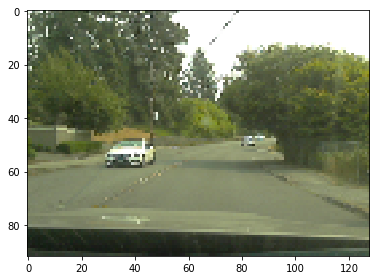

In [12]:

image = images[140]
print(images[23])
print(labels[140])
io.imshow(image)
io.show()

In [13]:

images = np.asarray(images)
images = images.reshape(len(images),width,height, 3)

In [14]:
labels = np.array(labels)
images = np.array(images)
print("labels: ", labels.shape, "\nimages: ", images.shape)

labels:  (678,) 
images:  (678, 128, 92, 3)


In [15]:
maxLength = trainingIndex
global currentPos
currentPos = 0
def nextTraining(batch_size):
    """ Return a batch of data. When dataset end is reached, start over.
    """
    #if self.batch_id == len(self.data):
    #    self.batch_id = 0
    #batch_data = (self.data[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #batch_labels = (self.labels[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #self.batch_id = min(self.batch_id + batch_size, len(self.data))
    global currentPos
    currentPos = currentPos + batch_size
    maxPos = currentPos + batch_size
    if(maxPos>maxLength):
        currentPos = 0
        maxPos = currentPos + batch_size
    batch_data = (images[currentPos:maxPos])
    batch_labels = (labels[currentPos:maxPos])
    return batch_data, batch_labels



In [16]:
maxTestingLength = len(labels)
global currentTestingPos
global minIndex 
minIndex = trainingIndex
currentTestingPos = minIndex

def nextTesting(batch_size):
    global currentTestingPos
    global minIndex
    currentTestingPos = currentTestingPos + batch_size
    maxPos = currentTestingPos + batch_size
    if(maxPos>maxTestingLength):
        currentTestingPos = minIndex
        maxPos = currentTestingPos + batch_size
    batch_data = (images[currentTestingPos:maxPos])
    batch_labels = (labels[currentTestingPos:maxPos])
    return batch_data, batch_labels

In [17]:
x, y = nextTraining(128)
print(x.shape)
print(y)

cellInitialized = 0

(128, 128, 92, 3)
[ 12.473255  10.644308  10.1964    12.083743  13.02306   12.993988
  12.878153  13.161146  12.503267   8.37061    8.382404   9.357316
  11.250753  10.486833   9.886907  10.027033  10.390247  10.763131
  11.367107  11.239316  10.895396   9.740769   8.574547   8.164906
   8.968207  10.358533  11.166475  10.83945   10.273601  10.707426
  10.13904    8.796385   8.121849   9.635711  12.042935  12.26999
  11.179085  11.237522  12.283283   9.971499 -10.53376  -10.526793
 -10.662712 -10.600086 -10.314669 -10.761782 -10.480239  -9.662266
  -8.387304  -8.868885  -9.668917 -10.070641  -8.758268  -9.577278
  -8.820137  -8.336675  -8.069673   8.169306   8.498271 -12.382215
 -12.990671 -16.058989 -17.831519 -19.347482 -19.54064  -16.745964
  -8.624837 -10.352064 -15.654312 -16.670692 -19.126551 -18.727342
 -17.546449 -15.83426  -13.086706 -13.308531 -13.742274 -14.528065
 -16.034146 -17.339296 -17.8608   -19.569827 -19.670158 -16.163617
 -12.342912  -9.038233   8.958952  11.228771 

In [18]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer()) 
# Parameters
learning_rate = 0.0001
training_epochs = 15
batch_size = 64
display_step = 10

# Network Parameters
n_input = width*height*3 # MNIST data input (img shape: 28*28)
n_classes = 1 # MNIST total classes (0-9 digits)

x = tf.placeholder(tf.float32, shape=[None, n_input])
y = tf.placeholder(tf.float32, shape=[None, n_classes])
W = tf.Variable(tf.zeros([n_input,n_classes]))
b = tf.Variable(tf.zeros([n_classes]))


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([9, 9, 3, 34])
b_conv1 = bias_variable([34])

x_image = tf.reshape(x, [-1,92,128,3])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 34, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([32 * 23 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1,32 * 23 *64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 1])
b_fc2 = bias_variable([1])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

pred = y_conv

accuracyFloor = tf.constant(0.1, tf.float32)

# Define loss and optimizer
loss = tf.maximum(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(pred, y)))),accuracyFloor)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Evaluate model
#correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(pred, y))))

# Initializing the variables
sess.run(tf.global_variables_initializer())



In [19]:
training_iters = 2400000
step =0
display_step = 150
# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = nextTraining(batch_size)
    # Reshape data to get 28 seq of 28 elements
    batch_x = batch_x.reshape((batch_size, n_input))
    batch_y = batch_y.reshape((batch_size, 1))
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
    if step % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        # Calculate batch loss
        cost = sess.run(loss, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(cost) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")


Iter 0, Minibatch Loss= 152.026306, Training Accuracy= 155.44380
Iter 9600, Minibatch Loss= 5.131161, Training Accuracy= 5.37536
Iter 19200, Minibatch Loss= 3.429736, Training Accuracy= 3.76919
Iter 28800, Minibatch Loss= 3.700728, Training Accuracy= 3.72549
Iter 38400, Minibatch Loss= 2.363323, Training Accuracy= 2.44808
Iter 48000, Minibatch Loss= 2.616464, Training Accuracy= 2.54874
Iter 57600, Minibatch Loss= 2.186168, Training Accuracy= 1.87606
Iter 67200, Minibatch Loss= 2.246094, Training Accuracy= 2.33926
Iter 76800, Minibatch Loss= 2.263218, Training Accuracy= 1.96436
Iter 86400, Minibatch Loss= 1.453461, Training Accuracy= 1.47067
Iter 96000, Minibatch Loss= 1.921741, Training Accuracy= 2.05392
Iter 105600, Minibatch Loss= 1.855593, Training Accuracy= 1.89119
Iter 115200, Minibatch Loss= 2.457190, Training Accuracy= 2.15579


KeyboardInterrupt: 

In [20]:
#Speed accuracy

step = 1
totalMAE = 0
correctDirectionCount = 0
totalCount = 0
threshold = 12
# Calculate accuracy for 128 mnist test images
while step * batch_size < (len(images)-trainingIndex):
    test_data, test_label = nextTesting(batch_size)
    test_data = test_data.reshape((batch_size, n_input))
    test_label = test_label.reshape((batch_size, 1))
    predAccuracy = sess.run(accuracy, feed_dict={x: test_data, y: test_label, keep_prob: 0.5})
    results = sess.run(pred, feed_dict={x: test_data, keep_prob: 0.5})
    #print(results)
    #print(test_label)
    for i in range(0,len(results)):
        element = results[i] * test_label[i]
        delta = abs(results[i] - test_label[i])
        if(abs(results[i])< 5):
            continue
        totalCount+=1
        print("Actual:", test_label[i],"Guess:",results[i],"Delta",delta)
        if element > 0:
            correctDirectionCount+=1
    totalMAE += predAccuracy
    print("Testing Accuracy:", predAccuracy)
    step+=1
print("Total MAE: ", (totalMAE/(step-1)))
print("Turn percentage", (totalCount/((step-1) * batch_size)))
print ("Correct Speed within threshold percentage ",(correctDirectionCount/totalCount))

Actual: [-17.65582] Guess: [-13.80266953] Delta [ 3.85315047]
Actual: [-16.552438] Guess: [-15.10558987] Delta [ 1.44684813]
Actual: [-16.368401] Guess: [-14.86882687] Delta [ 1.49957413]
Actual: [-16.08242] Guess: [-16.72366714] Delta [ 0.64124714]
Actual: [-18.317785] Guess: [-17.56223297] Delta [ 0.75555203]
Actual: [-18.115246] Guess: [-15.76752377] Delta [ 2.34772223]
Actual: [-18.262573] Guess: [-18.41568565] Delta [ 0.15311265]
Actual: [-18.562701] Guess: [-17.29880714] Delta [ 1.26389386]
Actual: [-18.57383] Guess: [-21.39473724] Delta [ 2.82090724]
Actual: [-17.099845] Guess: [-9.1556282] Delta [ 7.9442168]
Actual: [-11.870285] Guess: [-8.26522541] Delta [ 3.60505959]
Actual: [ 8.41698] Guess: [ 6.86888075] Delta [ 1.54809925]
Actual: [ 13.139709] Guess: [ 11.74118614] Delta [ 1.39852286]
Actual: [ 15.115562] Guess: [ 16.10484886] Delta [ 0.98928686]
Actual: [ 18.805232] Guess: [ 19.93759346] Delta [ 1.13236146]
Actual: [ 27.376375] Guess: [ 24.9969101] Delta [ 2.3794649]
Actu